# Implementing A Multi-Layer Artificial Neuron Network From Scratch

## Background

Artificial neuron network is the building block for deep learning algorithms. However, understanding how the artificial neuron network functions can be challenging, especially for self-taught students like myself. In this notebook, I share a multi-layer artificial neuron network that I developed from scratch with the feature of customizing the number of layers and the number of neurons in each layer. I also include the full math derivations using two simple examples to illustrate the principle of the algorithm. At the end, I also walk through the most important function in my classifier - the "fit" function - and explain step by step what the code does. I hope this little document can be helpful for people to better understand some basic logics behind the multi-layer articificial neuron network algorithms.

## An Overview of the code

Below is the full code for the feedforward neural network classifier:

In [1]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
class MultiNNClassifier(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
   
    Parameters
    ------------
    n_layers : int (default: 1)
        Number of hidden layers
    n_neurons : tuple or list (default: (4, 4))
        Number of neurons in each layer. e.g. n_neurons[0] -> number of neurons in the first hidden layer,
        n_neurons[1] -> number of neurons in the second hidden layer, etc.
    n_iter : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.01)
        Learning rate.
    minibatch_size : int (default: 1000)
        Number of training examples per minibatch.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    seed : int (default: None)
        Random seed for initializing weights and shuffling.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    early_stop: int (default: None)
        Classifier will cease before reaching n_iter if the accuracy does not change 
        for the given number of times.
    diff: float (default: 0.001)
        Difference between the accuracy values to trigger early stop.
    
    
    Attributes
    -----------
    accuracy_scores_ : Dictionary
        Dictionary collecting both the training accuracy and the validation accuracy for each iteration.
    last_iter_ : int
        An integer indicating the number of iterations performed before early stop happens.

    """
    
    def __init__(self, n_layers=1, n_neurons=[50], n_iter=200, eta=0.01, 
                 minibatch_size=1000, l2=0., seed=0, shuffle=True, early_stop=None, diff=0.001):
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.n_iter = n_iter
        self.eta = eta
        self.random = np.random.RandomState(seed)
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.l2 = l2
        self.early_stop = early_stop
        self.diff = diff
    
    def _one_hot(self, y):
        """Convert target values into one-hot shape
        
        Parameters
        -------------
        y : array, shape = [n_examples]
        
        Returns
        -----------
        one_hot_y : array, shape = [n_examples, m_unique_labels]
        
        """
        self.le = LabelEncoder()
        y_label = self.le.fit_transform(y)
        one_hot_y = np.zeros((y_label.shape[0], np.unique(y_label).shape[0]))
        for idx, label in enumerate(y_label):
            one_hot_y[idx, label] = 1
        return one_hot_y
    
    
    def _sigmoid(self, z):
        """Compute the sigmoid function result.

        Parameters
        ------------
        z : int or array
            Net input function

        Returns
        -----------
        The sigmoid function result of z

        """
        return 1/(1+np.exp(-z))
    
    
    def _init_weights(self, X, y):
        """Initialize weights for the hidden layers in the multi-layer neuron network

        Parameters
        ------------
        X : array, shape = [n_examples, k_neurons]
            Inputs of a layer
        y : array, shape = [n_examples, m_unique_labels]
            Target values


        Returns
        -----------
        weights : list of arrays
        bias : list of arrays

        """
        if len(self.n_neurons) != self.n_layers:
            raise ValueError("The length of n_neurons doesn't match the number of hidden layers;",
                             "got %d as the length of n_neurons and %d as the number of hidden layers"\
                             %(len(self.n_neurons), self.n_layers))
        weights = []
        bias = []
        for i in range(self.n_layers+1):
            if i == 0:
                # For the first layer, the number of rows of weight have to match 
                # the number of columns of X for matrix multiplication
                weights.append(self.random.normal(loc=0.0, scale=0.1, 
                                                  size=(X.shape[1], self.n_neurons[i])))
                bias.append(np.zeros(self.n_neurons[i]))
            elif i == self.n_layers:
                # For the last layer, the dimensions of output have to match the dimensions of y
                weights.append(self.random.normal(loc=0.0, scale=0.1, 
                                                  size=(weights[i-1].shape[1], y.shape[1])))
                bias.append(np.zeros(y.shape[1]))
            else:
                weights.append(self.random.normal(loc=0.0, scale=0.1, 
                                                  size=(weights[i-1].shape[1], self.n_neurons[i])))
                bias.append(np.zeros(self.n_neurons[i]))
        return weights, bias

    
    def _forward (self, X):
        """Compute the net input function and activation results by forward propagation

        Parameters
        ------------
        X : array, shape = [n_examples, k_neurons]
            Inputs of a layer

        Returns
        -----------
        z : List of arrays
            Net input function results for all layers
        a : List of arrays
            Activation results for all layers

        """
        z = [] 
        a = []
        for i in range(self.n_layers+1):
            if i == 0:
                z.append(np.dot(X, self.weights[i]) + self.bias[i])
                a.append(self._sigmoid(z[i]))
            else:
                z.append(np.dot(a[i-1], self.weights[i]) + self.bias[i])
                a.append(self._sigmoid(z[i]))
        return z, a
    
    
    def fit(self,X, y, validation_split=0.0):    
        """Learn weights from training data.

        Parameters
        ------------
        X : array, shape = [n_examples, k_features]
            Input layer with original features.
        y : array, shape = [n_examples]
            Target class labels.
        validation_split: float (default: 0.0)
            fraction of the training data for validation
            
        Returns
        -----------
        self

        """
        total_examples = X.shape[0]
        split = round(total_examples * (1 - validation_split))
        X_train, X_valid = X[:split], X[split:]
        y_train, y_valid = y[:split], y[split:] 
        y_train_one_hot = self._one_hot(y_train)
        # Initialize weights and bias
        self.weights, self.bias = self._init_weights(X_train, y_train_one_hot)
        if self.early_stop:
            count=0 # count for early stop
        self.accuracy_scores_={"Train":[], "Validation":[]}  
        for i in range(self.n_iter):
            indices = np.arange(X_train.shape[0])
            if self.shuffle:
                np.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0]-self.minibatch_size+1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx+self.minibatch_size]
                X_batch = X_train[batch_idx]
                y_batch = y_train_one_hot[batch_idx]      
                z, a = self._forward(X_batch) # Forward Propagation
                #########################################
                ######### Back Propagation ##############
                #########################################
                # Note that the errors and the delta_weights are stored in reverse order. 
                # i.e. for the last layer, the error and delta_weights are errors[0] and delta_weights[0]
                errors = [] # the errors between anticipated vs. predicted activation values
                delta_weights = [] # the values to adjust weights
                delta_bias = [] # the values to adjust bias
                for j in range(self.n_layers+1):
                    if j == 0:
                        errors.append(y_batch-a[self.n_layers])
                        delta_weights.append(-np.dot(a[self.n_layers-1].T, errors[j])
                                             -self.l2*self.weights[self.n_layers])
                        delta_bias.append(np.sum(errors[j], axis=0))
                    elif j == self.n_layers:
                        part_1 = np.dot(errors[j-1], self.weights[self.n_layers+1-j].T)
                        part_2 = np.multiply(a[self.n_layers-j], 1-a[self.n_layers-j])
                        errors.append(np.multiply(part_1, part_2))
                        delta_weights.append(-np.dot(X_batch.T, errors[j])
                                             -self.l2*self.weights[self.n_layers-j])
                        delta_bias.append(np.sum(errors[j], axis=0))
                    else:
                        part_1 = np.dot(errors[j-1], self.weights[self.n_layers+1-j].T)
                        part_2 = np.multiply(a[self.n_layers-j], 1-a[self.n_layers-j])
                        errors.append(np.multiply(part_1, part_2))
                        delta_weights.append(-np.dot(a[self.n_layers-1-j].T, errors[j])
                                             -self.l2*self.weights[self.n_layers-j])
                        delta_bias.append(np.sum(errors[j], axis=0))

                # Update weights
                for k in range(self.n_layers+1):
                    self.weights[k] -=  self.eta*delta_weights[self.n_layers-k]
                    self.bias[k] -= self.eta*delta_bias[self.n_layers-k]
            
            # Store accuracy score for each iteration
            train_accuracy_score = self.accuracy_score(X_train, y_train)
            if validation_split != 0.0:
                if (validation_split > 1) or (validation_split < 0):
                    raise ValueError("validation_split has to be a number between 0 and 1;",
                             "got %d as the validation_split" %validation_split)
                validation_accuracy_score = self.accuracy_score(X_valid, y_valid)
            self.accuracy_scores_["Train"].append(train_accuracy_score)
            self.accuracy_scores_["Validation"].append(validation_accuracy_score)
            # Early stop
            if self.early_stop and i>0:
                if (self.accuracy_scores_["Train"][i] - self.accuracy_scores_["Train"][i-1] <= self.diff)\
                and (self.accuracy_scores_["Validation"][i] - self.accuracy_scores_["Validation"][i-1] <= self.diff):
                    count += 1
                else:
                    count = 0
                if count >= self.early_stop:
                    self.last_iter_ = i # Record the last iteration when early stop happens
                    break
                
    
    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_examples]
            Predicted class labels.

        """
        z, a = self._forward(X)
        y_pred = self.le.inverse_transform(np.argmax(a[-1], axis=1))
        
        return y_pred
    
    
    def accuracy_score(self, X, y):
        """Compute the accuracy score.

        Parameters
        ------------
        X : array, shape = [n_examples, k_features]
            Input layer with original features.
        y : array, shape = [n_examples]
            Target class labels.
        Returns
        -----------
        accuracy_score : float
            The accuracy score of the predictions
        """
        y_pred = self.predict(X)
        accuracy_score = np.sum(y_pred==y)/len(y)
        return accuracy_score

# Use my classifier to predict hand-written digits

To verify if my classifier works, I tested it on probably one of the most popular datasets in deep learning: [The MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/). This dataset contains 60,000 handwritten digits images in 28x28 pixels and the corresponding correct labels as the training set, and 10,000 images and corresponding labels as the test set. I want to see whether my classifier can successfully classify the handwritten digits using various numbers of layers and neurons. 

## Load the dataset

In [2]:
import os
import numpy as np
import struct

train_labels_path = r"C:\DataScience\Jupyter Files\Neuron Network\MNIST Database of handwritten digits\train-labels.idx1-ubyte"
train_imgs_path = r"C:\DataScience\Jupyter Files\Neuron Network\MNIST Database of handwritten digits\train-images.idx3-ubyte"

with open(train_labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II', lbpath.read(8))
    labels = np.fromfile(lbpath, dtype=np.uint8)
    y_train = labels

    
with open(train_imgs_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
    # Reshape the images of 28x28 pixels into 1x784 pixels (a single line)
    images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)  
    # Standardize the pixel intensity value from 0 to 255 to -1 to 1
    images = ((images / 255.) - .5) * 2   
    X_train = images
    
test_labels_path = r"C:\DataScience\Jupyter Files\Neuron Network\MNIST Database of handwritten digits\t10k-labels.idx1-ubyte"
test_imgs_path = r"C:\DataScience\Jupyter Files\Neuron Network\MNIST Database of handwritten digits\t10k-images.idx3-ubyte"

with open(test_labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II', lbpath.read(8))
    labels = np.fromfile(lbpath, dtype=np.uint8)
    y_test = labels

    
with open(test_imgs_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
    # Reshape the images of 28x28 pixels into 1x784 pixels (a single line)
    images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784) 
    # Standardize the pixel intensity value from 0 to 255 to -1 to 1
    images = ((images / 255.) - .5) * 2   
    X_test = images

In [3]:
print ("X_train shape: %s" %(X_train.shape,))
print ("y_train shape: %s" %(y_train.shape,))
print ("X_test shape: %s" %(X_test.shape,))
print ("y_test shape: %s" %(y_test.shape,))

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)


Some of the images in X_train and X_test:

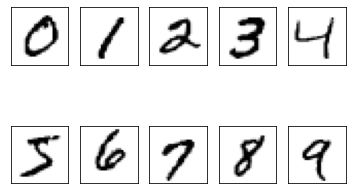

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()  
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.show()

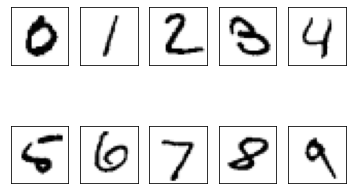

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()  
for i in range(10):
    img = X_test[y_test == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.show()

## Classification

#### Classify the handwritten digits using three layers (one hidden layer)

In [6]:
import time
start_time = time.time()
MNN_1 = MultiNNClassifier(n_layers=1, n_neurons=[80], n_iter=200, 
                          eta=0.0005, seed=1, minibatch_size=100, early_stop=10)
MNN_1.fit(X_train, y_train, validation_split=0.1)
end_time = time.time()
running_time = end_time - start_time
print("Training accuracy: %.3f" %MNN_1.accuracy_scores_["Train"][-1])
print("Validation accuracy: %.3f" %MNN_1.accuracy_scores_["Validation"][-1])
print("Testing accuracy: %.3f" %MNN_1.accuracy_score(X_test, y_test))
print("Number of iterations: %d" %MNN_1.last_iter_)
print("Running time: %s s" %running_time)

Training accuracy: 0.980
Validation accuracy: 0.973
Testing accuracy: 0.967
Number of iterations: 87
Running time: 72.24289679527283 s


It can be seen that my classifier sucessfully classified the handwritten digits in both the validation set and the test set with very high accuracy (over 95%), when using 80 neurons in the hidden layer. It can also be noticed that the classification stopped early at the 96th iteration, instead of the 200th iteration. To further verify that my classifier is truely working, I include some examples of correctly predicted and incorrectly predicted images:

Some examples of correctly predicted images:

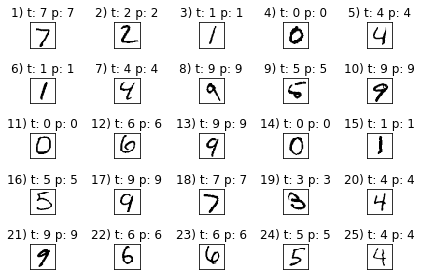

In [7]:
y_pred_test = MNN_1.predict(X_test)
pred_img = X_test[y_test == y_pred_test][:25]
correct_lab = y_test[y_pred_test == y_test][:25]
pred_lab = y_pred_test[y_test == y_pred_test][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = pred_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], pred_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Some examples of incorrectly predicted images:

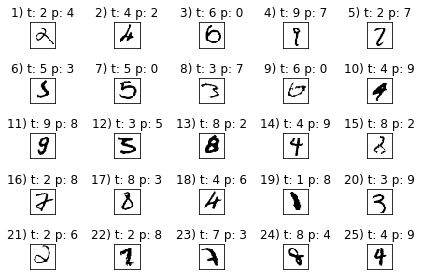

In [8]:
pred_img = X_test[y_test != y_pred_test][:25]
correct_lab = y_test[y_pred_test != y_test][:25]
pred_lab = y_pred_test[y_test != y_pred_test][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = pred_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], pred_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

#### Classify the handwritten digits using four layers (two hidden layers)

In [9]:
start_time = time.time()
MNN_2 = MultiNNClassifier(n_layers=2, n_neurons=[80,50], n_iter=200, 
                          eta=0.0005, seed=1, minibatch_size=100, early_stop=10)
MNN_2.fit(X_train, y_train, validation_split=0.1)
end_time = time.time()
running_time = end_time - start_time
print("Training accuracy: %.3f" %MNN_2.accuracy_scores_["Train"][-1])
print("Validation accuracy: %.3f" %MNN_2.accuracy_scores_["Validation"][-1])
print("Testing accuracy: %.3f" %MNN_2.accuracy_score(X_test, y_test))
print("Number of iterations: %d" %MNN_2.last_iter_)
print("Running time: %s s" %running_time)

Training accuracy: 0.984
Validation accuracy: 0.977
Testing accuracy: 0.971
Number of iterations: 66
Running time: 63.68178176879883 s


My classifier also works when I use four layers (two hidden layers). Also, there is a slight increase in the training and testing accuracy. Interestingly, adding one additional layer does not increase the running time (9 seconds faster than using 1 hidden layer), and it requires less number of iterations to converge (75 for two hidden layers vs. 96 for 1 hidden layer).

Some examples of correctly predicted images:

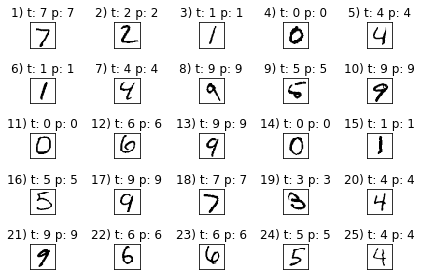

In [10]:
y_pred_test = MNN_1.predict(X_test)
pred_img = X_test[y_test == y_pred_test][:25]
correct_lab = y_test[y_pred_test == y_test][:25]
pred_lab = y_pred_test[y_test == y_pred_test][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = pred_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], pred_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Some examples of incorrectly predicted images:

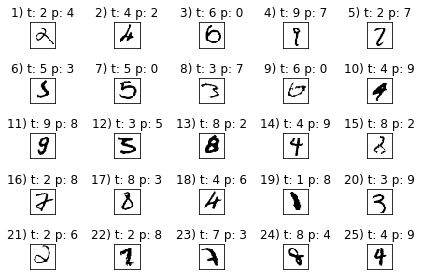

In [11]:
pred_img = X_test[y_test != y_pred_test][:25]
correct_lab = y_test[y_pred_test != y_test][:25]
pred_lab = y_pred_test[y_test != y_pred_test][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = pred_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], pred_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

#### Classify the handwritten digits using five layers (three hidden layers)

In [12]:
start_time = time.time()
MNN_3 = MultiNNClassifier(n_layers=3, n_neurons=[120,80,50], n_iter=200, 
                          eta=0.0005, seed=1, minibatch_size=100, early_stop=10)
MNN_3.fit(X_train, y_train, validation_split=0.1)
end_time = time.time()
running_time = end_time - start_time
print("Training accuracy: %.3f" %MNN_3.accuracy_scores_["Train"][-1])
print("Validation accuracy: %.3f" %MNN_3.accuracy_scores_["Validation"][-1])
print("Testing accuracy: %.3f" %MNN_3.accuracy_score(X_test, y_test))
print("Number of iterations: %d" %MNN_3.last_iter_)
print("Running time: %s s" %running_time)

Training accuracy: 0.999
Validation accuracy: 0.979
Testing accuracy: 0.974
Number of iterations: 117
Running time: 188.38093638420105 s


Using five layers (three hidden layers) the accuracy can be further increased. As a compenation, however, the running time is much longer than the previous models, and it requires more iterations to converge.

Some examples of correctly predicted images:

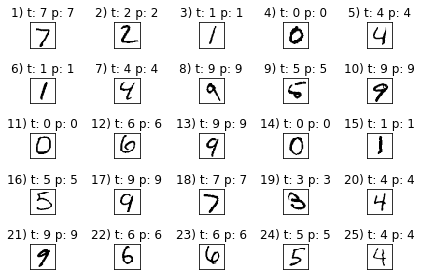

In [13]:
y_pred_test = MNN_1.predict(X_test)
pred_img = X_test[y_test == y_pred_test][:25]
correct_lab = y_test[y_pred_test == y_test][:25]
pred_lab = y_pred_test[y_test == y_pred_test][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = pred_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], pred_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Some examples of incorrectly predicted images:

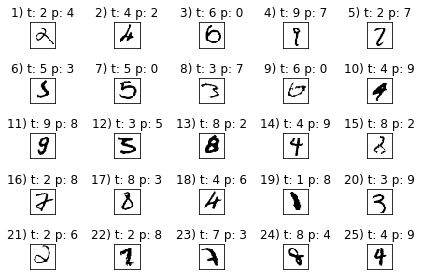

In [14]:
pred_img = X_test[y_test != y_pred_test][:25]
correct_lab = y_test[y_pred_test != y_test][:25]
pred_lab = y_pred_test[y_test != y_pred_test][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = pred_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], pred_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Math Behind the Multi-NN Classifier

### A single-input-single-target-value NN classifier

The feedforward neural network (NN) classifier consists of two major parts: forward-propagation and back-propagation. The forward-propagation uses the input values and the weights to predict the output values. The back-propagation finds the errors between the predicted output values and the true target values to adjust the weights. Since the math involved in multi-layer NN classifiers is not straight-forward, I start with a simple example. Consider a single-input-single-target-value NN classifier as below:

![image](single_path_NN_classifier.png)

Where 
- $a^n$ is the neuron in the $n^{th}$ layer
- $z^n$ is the net input function result in the $n^{th}$ layer
- $w^n$ is the weight in the $n^{th}$ layer
- $\phi$ is the activation function
- $X$ is the input value
- $y$ is the target value
- $\hat y$ is the predicted target value

#### Forward-Propagation

**In the forward-propagation**, from one layer to the next, we need to firstly take random guesses for each weight, and use these guessed weight values to find the net input function result:

$$ z^n = w^{n-1}a^{n-1} $$

Then, the neuron in the next layer is found by the activation function. I used sigmoid function as the activation function because sigmoid function suits well for classification problems:

$$a^n = \phi(z^n) = \frac{1}{1+e^{z^n}}$$

For example, from the $1^{st}$ layer to the $2^{nd}$ layer, the forward-propagation is:

$$z^2 = w^1a^1= w^1X$$ 

$$a^2 = \frac{1}{1+e^{z^2}}$$

By processing the forward-propagation till the $3{rd}$ layer (output layer), we will get a predicted y value. However, this predicted y value is likely to be wrong as we used the guessed weights. Therefore, we need to then implement the back-propagation to find the right weights.

#### Back-Propagation

**In the back-propagation**, we need to firstly define a cost function. Since I used the sigmoid function as the activation function, which is the activation function used in Logistic Regression, I then used the [cost function for Logistic Regression](https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148#:~:text=We%20can%20call%20a%20Logistic,instead%20of%20a%20linear%20function.) as well. The cost function is as follow:

$$J(w) = -\sum_{i=0}^{k}y_iln(a_i) + (1-y_i)ln(1-a_i)$$

Where
- $y_i$ indicates the $i^{th}$ sample in the target values
- $a_i$ indicates the $i^{th}$ sample in the output

To improve our model performance, we need to minimize the cost. The optimization algorithm I used here is the gradient descent algorithm. Since in this example, only one output $a^3$ and one target value $y$ are presented, the cost function can be simplified as:

$$J(w) = -\left[ yln(a^3) + (1-y)ln(1-a^3) \right]$$

Then, the gradient with respect to $w^2$ is:

$$\frac{\partial \mathbf{J}}{\partial w^2} = \frac{\partial \mathbf{J}}{\partial a^3} \cdot \frac{\partial \mathbf{a^3}} {\partial z^3} \cdot \frac{\partial \mathbf{z^3}}{\partial w^2}
=-\left[ y\frac{1}{a^3}+(1-y)\frac{-1}{1-a^3} \right] \cdot \left[ -\frac{1}{(1+e^{-z^3})^2}\cdot(-e^{-z^3}) \right] \cdot a^2 = -(y-a^3) \cdot a^2$$ 

Note that 

$$-\frac{1}{(1+e^{-z^3})^2}\cdot(-e^{-z^3}) = \frac{e^{-z^3}}{(1+e^{-z^3})^2} = \frac{1}{1+e^{-z^3}} \cdot (1-\frac{1}{1+e^{-z^3}}) = a^3 \cdot (1-a^3)$$

And the gradient with respect to $w^1$ is:

$$\frac{\partial \mathbf{J}}{\partial w^1} = \frac{\partial \mathbf{J}}{\partial a^3} \cdot \frac{\partial \mathbf{a^3}} {\partial z^3} \cdot \frac{\partial \mathbf{z^3}}{\partial a^2} \cdot \frac{\partial \mathbf{a^2}}{\partial z^2} \cdot \frac{\partial \mathbf{z^2}}{\partial w^1}
=-\left[ y\frac{1}{a^3}+(1-y)\frac{-1}{1-a^3} \right] \cdot \left[ a^3 \cdot (1-a^3) \right] \cdot [w^2] \cdot \left [a^2 \cdot (1-a^2) \right] \cdot a^1 $$

$$= - (y-a^3) \cdot w^2 \cdot [a^2 \cdot (1-a^2)] \cdot a^1$$ 

Note that to get $\frac{\partial \mathbf{J}}{\partial w^1}$ from $\frac{\partial \mathbf{J}}{\partial w^2}$, we only need to multiply $\frac{\partial \mathbf{J}}{\partial w^2}$ by $\frac{\partial \mathbf{z^3}}{\partial a^2} \cdot \frac{\partial \mathbf{a^2}}{\partial z^2}$ and change $\frac{\partial \mathbf{z^3}}{\partial w^2}$ to $\frac{\partial \mathbf{z^2}}{\partial w^1}$. This is because we implement the chain rule in the back-propagaton, and for each layer, the chain rule remains the same. Thus, if we define the error in the last layer as:

$$\delta^3 = \frac{\partial \mathbf{J}}{\partial a^3} \cdot \frac{\partial \mathbf{a^3}} {\partial z^3} = y-a^3$$

Then, the gradient with respect to $w^2$ becomes:

$$\frac{\partial \mathbf{J}}{\partial w^2} = -\delta^3 \cdot a^2$$

And the error in the second layer becomes:

$$\delta^2 = \frac{\partial \mathbf{J}}{\partial a^3} \cdot \frac{\partial \mathbf{a^3}} {\partial z^3} \cdot \frac{\partial \mathbf{z^3}}{\partial a^2} \cdot \frac{\partial \mathbf{a^2}}{\partial z^2} = \delta^3 \cdot \frac{\partial \mathbf{z^3}}{\partial a^2} \cdot \frac{\partial \mathbf{a^2}}{\partial z^2} = \delta^3 \cdot w^2 \cdot [a^2 \cdot (1-a^2)]$$

The gradient with respect to $w^1$ then becomes:

$$\frac{\partial \mathbf{J}}{\partial w^1} = -\delta^2 \cdot a^1$$

Based on the above derivation, we can summarize patterns for errors and the gradient as follow (you can further convince yourself that the patterns are true by using more layers of NN):

$$\delta^n = \delta^{n+1} \cdot w^n \cdot [a^n \cdot (1-a^n)]$$

$$\frac{\partial \mathbf{J}}{\partial w^n} = -\delta^{n+1} \cdot a^n$$

**These two equations are very important for developing the multi-layer neuron network algorithm, as they provide connections between the errors in one layer and the errors in the previous layer, as well as the relationship between the gradient of the weight and the error.** It is easy to find the errors in the last layer ($\delta^3$ in the above case) as it is simply the difference between the target value and the predicted value. By using the formula above, we can subsequently determine the errors layer by layer backwards, and then find the gradients with respect to the weights in each layer.

Finally, to update the weights, we simply substract the gradient multiplied by a learning rate $\eta$:

$$w^n := w^n - \eta\frac{\partial \mathbf{J}}{\partial w^n}$$

### A multiple-inputs multiple-target values NN classifier

Now that we have understood how the forward-propagation and back-propagation work in a single-input-single-target-value NN classifier. Let's see if the same patterns can be found in a multiple-inputs-multiple-target-values NN classifier:

![image](multiple_paths_NN_classifier.png)

Here we have a two-input two-target values system. Note that it is rare to classifier two target values using two features. The system is extremely simplified for demonstration purpose. 

Since now we have more than one samples in each layer, I use subscriptions to denote the samples.
- $a^n_i$ is the neuron for the $i^{th}$ sample in the $n^{th}$ layer
- $z^n_i$ is the net input function result for the $i^{th}$ sample in the $n^{th}$ layer
- $w^n_{ji}$ is the weight to find $z_j$ in the $n+1^{th}$ layer using $a_i$ in the $n^{th}$ layer
- $\phi$ is the activation function
- $X_i$ is the input value for the $i^{th}$ sample
- $y_i$ is the target value for the $i^{th}$ sample
- $\hat y_i$ is the predicted target value for the $i^{th}$ sample

#### Matrix Representation

To deal with multiple elements, it is better to take the advantages of matrix operations. First, we need to represent all elements in matrix forms.

Define:

$$A^1 = \begin{bmatrix} a^1_1 & a^1_2 \end{bmatrix} $$

$$A^2 = \begin{bmatrix} a^2_1 & a^2_2 & a^2_3\end{bmatrix} $$

$$A^3 = \begin{bmatrix} a^3_1 & a^3_2 \end{bmatrix} $$

$$Z^2 = \begin{bmatrix} z^2_1 & z^2_2 & z^2_3\end{bmatrix} $$

$$Z^3 = \begin{bmatrix} z^3_1 & z^3_2 \end{bmatrix} $$

$$W^1 = \begin{bmatrix} w^1_{11} & w^1_{21} & w^1_{31} \\ w^1_{12} & w^1_{22} & w^1_{32}\end{bmatrix} $$

$$W^2 = \begin{bmatrix} w^2_{11} & w^2_{21} \\ w^2_{12} & w^2_{22} \\ w^2_{13} & w^2_{23}\end{bmatrix} $$

$$Y = \begin{bmatrix} y_1 & y_2 \end{bmatrix} $$

#### Forward-Propagation

**In the forward-propagation**, again, we need to firstly take guesses for the weights. Then, we can calculate the net input result as follow:

$$ z^n_j = \sum_{i=0}^{k}w^{n-1}_{ji}a^{n-1}_i $$

For example:

$$ z^2_1 = w^1_{11} \cdot a^1_1 + w^1_{12} \cdot a^1_{2} $$

So, in matrix form:

$$ Z^n = A^{n-1}W^{n-1} $$

And the neurons are simply:

$$A^n = \phi(Z^n) $$

Which means that we apply the sigmoid function to each element in the $Z^n$.

#### Back-Propagation

The back-propagation for multi-inputs-multi-target-values system is tricker, as it involves matrix calculus. However, we can avoid doing the matrix calculus by looking for the patterns in the partial derivatives.

Again, the cost function is:

$$J(w) = -\sum_{i=0}^{k}y_iln(a_i) + (1-y_i)ln(1-a_i)$$

Since there are two target values and two predicted values, the cost function can be simplified as:

$$J(w) = - \left[ \left( y_1ln(a_1^3) + (1-y_1)ln(1-a_1^3) \right) + \left( y_2ln(a_2^3) + (1-y_2)ln(1-a_2^3) \right) \right]$$

Again, we need to find the gradient of $J$ with respect to each weight. Let's start with the weights in the second layer. It can be noticed that $w^2_{11}$, $w^2_{12}$, and $w^2_{13}$ are only used when calculating $z^3_1$, and $w^2_{21}$, $w^2_{22}$, and $w^2_{23}$ are only involved when calculating $z^3_2$. Therefore, we can express the gradients as:

$$\frac{\partial \mathbf{J}}{\partial w^2_{1i}} = \frac{\partial \mathbf{J}}{\partial a^3_1} \cdot \frac{\partial \mathbf{a^3_1}} {\partial z^3_1} \cdot \frac{\partial \mathbf{z^3_1}}{\partial w^2_{1i}}
=-\left[ y_1\frac{1}{a^3_1}+(1-y_1)\frac{-1}{1-a^3_1} \right] \cdot \left[ -\frac{1}{(1+e^{-z^3_1})^2}\cdot(-e^{-z^3_1}) \right] \cdot a^2_i = -(y_1-a^3_1) \cdot a^2_i$$ 

$$\frac{\partial \mathbf{J}}{\partial w^2_{2i}} = \frac{\partial \mathbf{J}}{\partial a^3_2} \cdot \frac{\partial \mathbf{a^3_2}} {\partial z^3_2} \cdot \frac{\partial \mathbf{z^3_2}}{\partial w^2_{2i}}
=-\left[ y_2\frac{1}{a^3_2}+(1-y_2)\frac{-1}{1-a^3_2} \right] \cdot \left[ -\frac{1}{(1+e^{-z^3_2})^2}\cdot(-e^{-z^3_2}) \right] \cdot a^2_i = -(y_2-a^3_2) \cdot a^2_i$$ 

Or:

$$\frac{\partial \mathbf{J}}{\partial w^2_{ji}} = -(y_j-a^3_j) \cdot a^2_i$$ 

Thus, if we define the error vector as:

$$ \delta^3 = \begin{bmatrix} y_1 - a^3_1 & y_2 - a^3_2 \end{bmatrix} = Y-A^3 $$

The gradients with respect to $w^2_{ji}$ as a matrix becomes:

$$ \frac{\partial \mathbf{J}}{\partial W^2} = -\left( A^2 \right)^T \cdot \delta^3 = -\begin{bmatrix} \frac{\partial \mathbf{J}}{\partial w^2_{11}} & \frac{\partial \mathbf{J}}{\partial w^2_{21}} \\ \frac{\partial \mathbf{J}}{\partial w^2_{12}} & \frac{\partial \mathbf{J}}{\partial w^2_{22}} \\ \frac{\partial \mathbf{J}}{\partial w^2_{13}} & \frac{\partial \mathbf{J}}{\partial w^2_{23}}\end{bmatrix}$$ 

Similarly, for the weights in the first layer, tt can be noticed that $w^1_{11}$, $w^1_{12}$ are only used when calculating $z^2_1$; $w^1_{21}$, $w^1_{22}$ are only used when calculating $z^2_2; w^2_{31}$, $w^2_{32}$ are only involved when calculating $z^2_3$. Thus:

$$\frac{\partial \mathbf{J}}{\partial w^1_{1i}} = \frac{\partial \mathbf{J}}{\partial a^2_1} \cdot \frac{\partial \mathbf{a^2_1}}{\partial z^2_1} \cdot \frac{\partial \mathbf{z^2_1}}{\partial w^1_{1i}} = \left( \frac{\partial \mathbf{J}}{\partial a^3_1} \cdot \frac{\partial \mathbf{a^3_1}} {\partial z^3_1} \cdot \frac{\partial \mathbf{z^3_1}}{\partial a^2_1} + \frac{\partial \mathbf{J}}{\partial a^3_2} \cdot \frac{\partial \mathbf{a^3_2}} {\partial z^3_2} \cdot \frac{\partial \mathbf{z^3_2}}{\partial a^2_1} \right) \cdot \frac{\partial \mathbf{a^2_1}}{\partial z^2_1} \cdot \frac{\partial \mathbf{z^2_1}}{\partial w^1_{1i}}$$

$$=- \left[ (y_1 - a_1^3)w_{11}^2 + (y_2 - a_2^3)w^2_{21} \right] \cdot \left[ a_1^2 \cdot (1-a_1^2) \right] \cdot a_i^1$$

$$\frac{\partial \mathbf{J}}{\partial w^1_{2i}} = \frac{\partial \mathbf{J}}{\partial a^2_2} \cdot \frac{\partial \mathbf{a^2_2}}{\partial z^2_2} \cdot \frac{\partial \mathbf{z^2_2}}{\partial w^1_{2i}} = \left( \frac{\partial \mathbf{J}}{\partial a^3_1} \cdot \frac{\partial \mathbf{a^3_1}} {\partial z^3_1} \cdot \frac{\partial \mathbf{z^3_1}}{\partial a^2_2} + \frac{\partial \mathbf{J}}{\partial a^3_2} \cdot \frac{\partial \mathbf{a^3_2}} {\partial z^3_2} \cdot \frac{\partial \mathbf{z^3_2}}{\partial a^2_2} \right) \cdot \frac{\partial \mathbf{a^2_2}}{\partial z^2_2} \cdot \frac{\partial \mathbf{z^2_2}}{\partial w^1_{2i}}$$

$$=- \left[ (y_1 - a_1^3)w_{12}^2 + (y_2 - a_2^3)w^2_{22} \right] \cdot \left[ a_2^2 \cdot (1-a_2^2) \right] \cdot a_i^1$$

$$\frac{\partial \mathbf{J}}{\partial w^1_{3i}} = \frac{\partial \mathbf{J}}{\partial a^3_2} \cdot \frac{\partial \mathbf{a^2_2}}{\partial z^2_2} \cdot \frac{\partial \mathbf{z^2_2}}{\partial w^1_{3i}} = \left( \frac{\partial \mathbf{J}}{\partial a^3_1} \cdot \frac{\partial \mathbf{a^3_1}} {\partial z^3_1} \cdot \frac{\partial \mathbf{z^3_1}}{\partial a^2_3} + \frac{\partial \mathbf{J}}{\partial a^3_2} \cdot \frac{\partial \mathbf{a^3_2}} {\partial z^3_2} \cdot \frac{\partial \mathbf{z^3_2}}{\partial a^2_3} \right) \cdot \frac{\partial \mathbf{a^2_3}}{\partial z^2_3} \cdot \frac{\partial \mathbf{z^2_3}}{\partial w^1_{3i}}$$

$$=- \left[ (y_1 - a_1^3)w_{13}^2 + (y_2 - a_2^3)w^2_{23} \right] \cdot \left[ a_3^2 \cdot (1-a_3^2) \right] \cdot a_i^1$$

Or:

$$ \frac{\partial \mathbf{J}}{\partial w^1_{ji}} =- \left[ (y_1 - a_1^3)w_{1j}^2 + (y_2 - a_2^3)w^2_{2j} \right] \cdot \left[ a_j^2 \cdot (1-a_j^2) \right] \cdot a_i^1$$

Note that $a^2_i$ is involved when calculating both $z^3_1$ and $z^3_2$.

If we take a closer look at the first term of $\frac{\partial \mathbf{J}}{\partial w^1_{ji}}$, we can see that it is essentially the dot product of $\delta^3$ and $(W^2)^T$:

$$ \delta^3 \cdot (W^2)^T = \begin{bmatrix} y_1 - a^3_1 & y_2 - a^3_2 \end{bmatrix} \cdot \begin{bmatrix} w^2_{11} & w^2_{12} & w^2_{13} \\ w^2_{21} & w^2_{22} & w^2_{23}\end{bmatrix} $$

$$ = \begin{bmatrix} (y_1 - a^3_1)w^2_{11} + (y_2 - a^3_2)w^2_{21} & (y_1 - a^3_1)w^2_{12} + (y_2 - a^3_2)w^2_{22} & (y_1 - a^3_1)w^2_{13} + (y_2 - a^3_2)w^2_{23}  \end{bmatrix} $$

Then, we can get the errors in the first layer:

$$ \delta^2 = \delta^3 \cdot (W^2)^T \otimes \left[ A^2 \otimes (1-A^2) \right] $$

$$ =\begin{bmatrix} \left( (y_1 - a_1^3)w_{11}^2 + (y_2 - a_2^3)w^2_{21} \right) \cdot \left( a_1^2 \cdot (1-a_1^2) \right) & \left( (y_1 - a_1^3)w_{12}^2 + (y_2 - a_2^3)w^2_{22} \right) \cdot \left( a_2^2 \cdot (1-a_2^2) \right) & \left( (y_1 - a_1^3)w_{13}^2 + (y_2 - a_2^3)w^2_{23} \right) \cdot \left( a_3^2 \cdot (1-a_3^2) \right)  \end{bmatrix} $$

Where $\otimes$ is the element wise multiplication.

Finally the gradients with respect to $w^1$ in a matrix form is:

$$ \frac{\partial \mathbf{J}}{\partial W^1} = -(A^1)^T \cdot \delta^2 = -\begin{bmatrix}\frac{\partial \mathbf{J}}{\partial w^1_{11}} & \frac{\partial \mathbf{J}}{\partial w^1_{21}} & \frac{\partial \mathbf{J}}{\partial w^1_{31}} \\ \frac{\partial \mathbf{J}}{\partial w^1_{12}} & \frac{\partial \mathbf{J}}{\partial w^1_{22}} & \frac{\partial \mathbf{J}}{\partial w^1_{32}}\end{bmatrix} $$

Therefore, the patterns that we can recognize are:

$$ \delta^{n} = \delta^{n+1} \cdot (W^n)^T \otimes \left[ A^n \otimes (1-A^n) \right] $$

$$ \frac{\partial \mathbf{J}}{\partial W^n} = -(A^n)^T \cdot \delta^{n+1}  $$

And the weights can be updated using the gradients:

$$W^n := W_n - \eta \cdot \frac{\partial \mathbf{J}}{\partial w^n}$$

# Code Walk Through

Now that we have understood the math behind the classifier, I will walk you through the most important function in my classifier: the "fit" function. For your convenience, I paste the "fit" function below:

In [15]:
   def fit(self,X, y, validation_split=0.0):    
        """Learn weights from training data.

        Parameters
        ------------
        X : array, shape = [n_examples, k_features]
            Input layer with original features.
        y : array, shape = [n_examples]
            Target class labels.
        validation_split: float (default: 0.0)
            fraction of the training data for validation
            
        Returns
        -----------
        self

        """
        total_examples = X.shape[0]
        split = round(total_examples * (1 - validation_split))
        X_train, X_valid = X[:split], X[split:]
        y_train, y_valid = y[:split], y[split:] 
        y_train_one_hot = self._one_hot(y_train)
        # Initialize weights and bias
        self.weights, self.bias = self._init_weights(X_train, y_train_one_hot)
        if self.early_stop:
            count=0 # count for early stop
        self.accuracy_scores_={"Train":[], "Validation":[]}  
        for i in range(self.n_iter):
            indices = np.arange(X_train.shape[0])
            if self.shuffle:
                np.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0]-self.minibatch_size+1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx+self.minibatch_size]
                X_batch = X_train[batch_idx]
                y_batch = y_train_one_hot[batch_idx]      
                z, a = self._forward(X_batch) # Forward Propagation
                #########################################
                ######### Back Propagation ##############
                #########################################
                # Note that the errors and the delta_weights are stored in reverse order. 
                # i.e. for the last layer, the error and delta_weights are errors[0] and delta_weights[0]
                errors = [] # the errors between anticipated vs. predicted activation values
                delta_weights = [] # the values to adjust weights
                delta_bias = [] # the values to adjust bias
                for j in range(self.n_layers+1):
                    if j == 0:
                        errors.append(y_batch-a[self.n_layers])
                        delta_weights.append(-np.dot(a[self.n_layers-1].T, errors[j])
                                             -self.l2*self.weights[self.n_layers])
                        delta_bias.append(np.sum(errors[j], axis=0))
                    elif j == self.n_layers:
                        part_1 = np.dot(errors[j-1], self.weights[self.n_layers+1-j].T)
                        part_2 = np.multiply(a[self.n_layers-j], 1-a[self.n_layers-j])
                        errors.append(np.multiply(part_1, part_2))
                        delta_weights.append(-np.dot(X_batch.T, errors[j])
                                             -self.l2*self.weights[self.n_layers-j])
                        delta_bias.append(np.sum(errors[j], axis=0))
                    else:
                        part_1 = np.dot(errors[j-1], self.weights[self.n_layers+1-j].T)
                        part_2 = np.multiply(a[self.n_layers-j], 1-a[self.n_layers-j])
                        errors.append(np.multiply(part_1, part_2))
                        delta_weights.append(-np.dot(a[self.n_layers-1-j].T, errors[j])
                                             -self.l2*self.weights[self.n_layers-j])
                        delta_bias.append(np.sum(errors[j], axis=0))

                # Update weights
                for k in range(self.n_layers+1):
                    self.weights[k] -=  self.eta*delta_weights[self.n_layers-k]
                    self.bias[k] -= self.eta*delta_bias[self.n_layers-k]
            
            # Store accuracy score for each iteration
            train_accuracy_score = self.accuracy_score(X_train, y_train)
            if validation_split != 0.0:
                if (validation_split > 1) or (validation_split < 0):
                    raise ValueError("validation_split has to be a number between 0 and 1;",
                             "got %d as the validation_split" %validation_split)
                validation_accuracy_score = self.accuracy_score(X_valid, y_valid)
            self.accuracy_scores_["Train"].append(train_accuracy_score)
            self.accuracy_scores_["Validation"].append(validation_accuracy_score)
            # Early stop
            if self.early_stop and i>0:
                if (self.accuracy_scores_["Train"][i] - self.accuracy_scores_["Train"][i-1] <= self.diff)\
                and (self.accuracy_scores_["Validation"][i] - self.accuracy_scores_["Validation"][i-1] <= self.diff):
                    count += 1
                else:
                    count = 0
                if count >= self.early_stop:
                    self.last_iter_ = i
                    break
                

The first thing that the "fit" function does is to convert y into its [one hot form](https://en.wikipedia.org/wiki/One-hot), by using the _one_hot() function, as shown below.

In [16]:
def _one_hot(self, y):
    """Convert target values into one-hot shape

    Parameters
    -------------
    y : array, shape = [n_examples]

    Returns
    -----------
    one_hot_y : array, shape = [n_examples, m_unique_labels]

    """
    self.le = LabelEncoder()
    y_label = self.le.fit_transform(y)
    one_hot_y = np.zeros((y_label.shape[0], np.unique(y_label).shape[0]))
    for idx, label in enumerate(y_label):
        one_hot_y[idx, label] = 1
    return one_hot_y

The one hot form of a label vector y is essentially a matrix in which its row indices represent the indices of the label and the column indicies represent the unique labels. The one hot form is used because the labels contain digits from 0 to 9 and we don't want to confuse the classifier. If we don't use the one hot form, the classifier will consider label 2 is larger than label 1, which is not true. An example of how the function works:

In [17]:
y = np.array(['a', 2, 'b', 3, 2, 'a'])
MNN = MultiNNClassifier()
one_hot_y = MNN._one_hot(y)
print("y: ")
print(y)
print("y in one hot form: ")
print(one_hot_y)

y: 
['a' '2' 'b' '3' '2' 'a']
y in one hot form: 
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


Then, the weights and bias are initialized through a function called _init_weights(). [Bias](https://intellipaat.com/community/253/role-of-bias-in-neural-networks#:~:text=Bias%20is%20like%20the%20intercept,best%20for%20the%20given%20data.) is an additional parameter in the neural network to adjust the output along with the weighted sum of the inputs to the neuron . Each layer of neural network has one bias. If we consider the bias to the net input, the formula becomes:

$$ Z^n = A^{n-1}W^{n-1} + B^{n-1}$$

Where $B^{n-1}$ is the bias array.

In [18]:
def _init_weights(self, X, y):
    """Initialize weights for the hidden layers in the multi-layer neuron network

    Parameters
    ------------
    X : array, shape = [n_examples, k_neurons]
        Inputs of a layer
    y : array, shape = [n_examples, m_unique_labels]
        Target values


    Returns
    -----------
    weights : list of arrays
    bias : list of arrays

    """
    if len(self.n_neurons) != self.n_layers:
        raise ValueError("The length of n_neurons doesn't match the number of hidden layers;",
                         "got %d as the length of n_neurons and %d as the number of hidden layers"\
                         %(len(self.n_neurons), self.n_layers))
    weights = []
    bias = []
    for i in range(self.n_layers+1):
        if i == 0:
            # For the first layer, the number of rows of weight have to match 
            # the number of columns of X for matrix multiplication
            weights.append(self.random.normal(loc=0.0, scale=0.1, 
                                              size=(X.shape[1], self.n_neurons[i])))
            bias.append(np.zeros(self.n_neurons[i]))
        elif i == self.n_layers:
            # For the last layer, the dimensions of output have to match the dimensions of y
            weights.append(self.random.normal(loc=0.0, scale=0.1, 
                                              size=(weights[i-1].shape[1], y.shape[1])))
            bias.append(np.zeros(y.shape[1]))
        else:
            weights.append(self.random.normal(loc=0.0, scale=0.1, 
                                              size=(weights[i-1].shape[1], self.n_neurons[i])))
            bias.append(np.zeros(self.n_neurons[i]))
    return weights, bias


Here, weights and bias are initiated as empty lists. Then, the weights and bias in each layer are appended into the lists, so that the first elements in the lists are the weights and bias in the first layer, the second elements in the lists are the weights and bias in the second layer, and so on. The most important part here is to identify the right dimensions of the weights and bias arrays. Since we use the dot product of $A^{n-1}$ and $W^{n-1}$ to find $Z^n$, the number of rows of $W^{n-1}$ has to match the number of columns of $A^{n-1}$, and the number of columns of $W^{n-1}$ has to match the number of columns of $Z^n$. Also, the dimensions of the bias $B^{n-1}$ should be the same as the dimensions of $Z^n$.

Then, in a given number of iterations, the function firstly shuffle the indices, and split the entire training set into mini-batches to improve the computational efficiency. After that, the output values are calculated by the forward-propagation through _foward() function. 

In [19]:
def _forward (self, X):
    """Compute the net input function and activation results by forward propagation

    Parameters
    ------------
    X : array, shape = [n_examples, k_neurons]
        Inputs of a layer

    Returns
    -----------
    z : List of arrays
        Net input function results for all layers
    a : List of arrays
        Activation results for all layers

    """
    z = [] 
    a = []
    for i in range(self.n_layers+1):
        if i == 0:
            z.append(np.dot(X, self.weights[i]) + self.bias[i])
            a.append(self._sigmoid(z[i]))
        else:
            z.append(np.dot(a[i-1], self.weights[i]) + self.bias[i])
            a.append(self._sigmoid(z[i]))
    return z, a

Essentially, the forward-propagation uses two formulas mentioned above:

$$ Z^n = A^{n-1}W^{n-1} + B^{n-1}$$

$$ A^n = \phi (Z^n) $$

Afterwards, the back-propagation is implemented to find the gradients with respect to each weight and bias to update the weights and bias. The back-propagation algorithm is essentially the implementation of the patterns I mentioned above: 

$$ \delta^{n} = \delta^{n+1} \cdot (W^n)^T \otimes \left[ A^n \otimes (1-A^n) \right] $$

$$ \frac{\partial \mathbf{J}}{\partial W^n} = -(A^n)^T \cdot \delta^{n+1}  $$

Note that since the variables are determined backwards from the last layer to the first, the orders for errors, delta_weights, and delta_bias are inversed. 